# 🧪 Leave-X-Out (LXO) Subsampling Strategy — Sampling Plan Generation

## 🎯 Goal

This notebook generates **sampling masks** for each patient and each LXO configuration, to enable **uncertainty quantification via structured k-space dropout**.

The LXO method removes a fixed subset of **phase-encoding lines** from the k-space data in each sub-reconstruction. By varying which lines are left out in each sub-sample, we can simulate multiple plausible reconstructions and compute voxelwise standard deviation (UQ map).

---

## 📐 What This File Does

For every patient:
1. Load the k-space
2. Define a set of **LXO sampling masks** — each one represents a sub-reconstruction where specific echo trains (lines) are removed
3. Store:
   - Patient ID
   - Acceleration factor
   - LXO config (e.g. `X=4` 4 echo trains are left out)
   - For each sub-reconstruction: the **retained line indices**

---

## 🗂️ Output

We save the sampling index information in a **SQLite database**, so that later:
- During inference, we can load the sampling masks per patient/sub-reconstruction
- The DL model can reconstruct from **only the retained lines** per sub-sample
- UQ maps can be generated via **voxelwise std-dev** over sub-reconstructions

---

## 📊 Why This Matters

Unlike Gaussian noise-based UQ, LXO targets **structured sensitivity** to missing k-space regions — which may better simulate real-world signal variations and improve correlation with hallucination-prone areas.

---


In [10]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from typing import List, Dict, Tuple, Union


# All patient IDs to consider for Uncertainty Quantification
pat_ids = [
    # '0003_ANON5046358',
    '0004_ANON9616598',
    # '0005_ANON8290811',
    # '0006_ANON2379607',
    # '0007_ANON1586301',
    # '0008_ANON8890538',
    # '0010_ANON7748752',
    # '0011_ANON1102778',
    # '0012_ANON4982869',
    # '0013_ANON7362087',
    # '0014_ANON3951049',
    # '0015_ANON9844606',
    # '0018_ANON9843837',
    # '0019_ANON7657657',
    # '0020_ANON1562419',
    # '0021_ANON4277586',
    # '0023_ANON6964611',
    # '0024_ANON7992094',
    # '0026_ANON3620419',
    # '0027_ANON9724912',
    # '0028_ANON3394777',
    # '0029_ANON7189994',
    # '0030_ANON3397001',
    # '0031_ANON9141039',
    # '0032_ANON7649583',
    # '0033_ANON9728185',
    # '0035_ANON3474225',
    # '0036_ANON0282755',
    # '0037_ANON0369080',
    # '0039_ANON0604912',
    # '0042_ANON9423619',
    # '0043_ANON7041133',
    # '0044_ANON8232550',
    # '0045_ANON2563804',
    # '0047_ANON3613611',
    # '0048_ANON6365688',
    # '0049_ANON9783006',
    # '0051_ANON1327674',
    # '0052_ANON9710044',
    # '0053_ANON5517301',
    # '0055_ANON3357872',
    # '0056_ANON2124757',
    # '0057_ANON1070291',
    # '0058_ANON9719981',
    # '0059_ANON7955208',
    # '0061_ANON7642254',
    # '0062_ANON0319974',
    # '0063_ANON9972960',
    # '0064_ANON0282398',
    # '0067_ANON0913099',
    # '0068_ANON7978458',
    # '0069_ANON9840567',
    # '0070_ANON5223499',
    # '0071_ANON9806291',
    # '0073_ANON5954143',
    # '0075_ANON5895496',
    # '0076_ANON3983890',
    # '0077_ANON8634437',
    # '0078_ANON6883869',
    # '0079_ANON8828023',
    # '0080_ANON4499321',
    # '0081_ANON9763928',
    # '0082_ANON6073234',
    # '0083_ANON9898497',
    # '0084_ANON6141178',
    # '0085_ANON4535412',
    # '0086_ANON8511628',
    # '0087_ANON9534873',
    # '0088_ANON9892116',
    # '0089_ANON9786899',
    # '0090_ANON0891692',
    # '0092_ANON9941969',
    # '0093_ANON9728761',
    # '0094_ANON8024204',
    # '0095_ANON4189062',
    # '0097_ANON5642073',
    # '0103_ANON8583296',
    # '0104_ANON7748630',
    # '0105_ANON9883201',
    # '0107_ANON4035085',
    # '0108_ANON0424679',
    # '0109_ANON9816976',
    # '0110_ANON8266491',
    # '0111_ANON9310466',
    # '0112_ANON3210850',
    # '0113_ANON9665113',
    # '0115_ANON0400743',
    # '0116_ANON9223478',
    # '0118_ANON7141024',
    # '0119_ANON3865800',
    # '0120_ANON7275574',
    # '0121_ANON9629161',
    # '0123_ANON7265874',
    # '0124_ANON8610762',
    # '0125_ANON0272089',
    # '0126_ANON4747182',
    # '0127_ANON8023509',
    # '0128_ANON8627051',
    # '0129_ANON5344332',
    # '0135_ANON9879440',
    # '0136_ANON8096961',
    # '0137_ANON8035619',
    # '0138_ANON1747790',
    # '0139_ANON2666319',
    # '0140_ANON0899488',
    # '0141_ANON8018038',
    # '0142_ANON7090827',
    # '0143_ANON9752849',
    # '0144_ANON2255419',
    # '0145_ANON0335209',
    # '0146_ANON7414571',
    # '0148_ANON9604223',
    # '0149_ANON4712664',
    # '0150_ANON5824292',
    # '0152_ANON2411221',
    # '0153_ANON5958718',
    # '0155_ANON7828652',
    # '0157_ANON9873056',
    # '0159_ANON9720717',
    # '0160_ANON3504149'
]

roots = {
    'kspace':            Path('/scratch/p290820/datasets/003_umcg_pst_ksps'),
    'reader_study':      Path('/scratch/hb-pca-rad/projects/03_reader_set_v2'),
    'reader_study_segs': Path('/scratch/hb-pca-rad/projects/03_reader_set_v2/segs'),
    'R3_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    'R6_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x"),
    'db_fpath_old':      Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db'),                  # References an OLDER version of the databases where the info could also just be fine that we are looking for
    'db_fpath_new':      Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db'),    # References the LATEST version of the databases where the info could also just be fine that we are looking for
    'figures_gaussian':  Path('/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/figures'),
}

acc_factors         = [3, 6] # Define the set of acceleration factors we care about.
acc_factors         = [3] # Define the set of acceleration factors we care about.

tablename = 'echo_train_mapping_debug'
tablename = 'echo_train_mapping'

In [4]:
def load_kspace_data(pat_ids: List[str], acc_factors: List[int], roots: Dict[str, Path]) -> List[Dict]:
    """
    Load k-space data and ISMRMRD headers from h5 files.

    This function reads the header data as a string while the file is open,
    ensuring the stored header is valid after file closure.

    Parameters:
        pat_ids (list): List of patient IDs.
        acc_factors (list): List of acceleration factors.
        roots (dict): Dictionary with key 'kspace' pointing to the root directory.

    Returns:
        list: A list of dictionaries, each containing patient ID, acceleration factor,
              k-space data, and the header string.
    """
    kspaces = []
    for patient_id in pat_ids:
        for acc in acc_factors:
            kspace_dir = roots['kspace'] / 'data' / patient_id / 'h5s'
            kspace_files = list(kspace_dir.glob("*.h5"))
            assert len(kspace_files) == 1, f"Expected 1 kspace file for {patient_id}, found {len(kspace_files)}"
            
            with h5py.File(kspace_files[0], 'r') as f:
                kspace_data = f['kspace'][:]
                
                # Convert the header dataset to a string while the file is open.
                header_dataset = f['ismrmrd_header']
                header_str = header_dataset.asstr()[()]
                kspaces.append({
                    'id': patient_id,
                    'acc': acc,
                    'kspace': kspace_data,
                    'ismrmrd_header': header_str,
                })
            print(f"Loaded kspace data for patient {patient_id} with acceleration factor {acc}")
            
    return kspaces


kspaces = load_kspace_data(pat_ids, acc_factors, roots)

Loaded kspace data for patient 0004_ANON9616598 with acceleration factor 3


In [5]:
def print_ismrmrd_headers(kspaces):
    """
    Print the ISMRMRD headers from each k-space entry.
    
    Parameters:
        kspaces (list): List of dictionaries containing header strings.
    """
    for entry in kspaces:
        print(f"Patient ID: {entry['id']}, Acc Factor: {entry['acc']}")
        print("ISMRMRD Header:")
        print(entry['ismrmrd_header'])
        print("-" * 80)

print_ismrmrd_headers(kspaces)

Patient ID: 0004_ANON9616598, Acc Factor: 3
ISMRMRD Header:
<?xml version="1.0" ?>
<ns0:ismrmrdHeader xmlns:ns0="http://www.ismrm.org/ISMRMRD">
  <ns0:studyInformation>
    <ns0:studyTime>None</ns0:studyTime>
  </ns0:studyInformation>
  <ns0:measurementInformation>
    <ns0:measurementID>46133_44815753_44815761_460</ns0:measurementID>
    <ns0:patientPosition>patientPositionType.HFS</ns0:patientPosition>
    <ns0:protocolName>T2_TSE_tra obl</ns0:protocolName>
    <ns0:measurementDependency>
      <ns0:dependencyType>SenMap</ns0:dependencyType>
      <ns0:measurementID>46133_44815753_44815761_445</ns0:measurementID>
    </ns0:measurementDependency>
    <ns0:measurementDependencyType>
      <ns0:dependencyType>Noise</ns0:dependencyType>
      <ns0:measurementID>46133_44815753_44815761_445</ns0:measurementID>
    </ns0:measurementDependencyType>
    <ns0:frameOfReferenceUID>None</ns0:frameOfReferenceUID>
  </ns0:measurementInformation>
  <ns0:acquisitionSystemInformation>
    <ns0:systemV

In [6]:
# Here is the code to load kspace data and print the ISMRMRD headers.

# 1. Kspace Loading
avg1, avg2, avg3 = 0, 1, 2
kspaces = [] # Placeholder for kspace data list of dicts with Dict[str, Any]
for id in pat_ids:
    for acc in acc_factors:
        kspace_fpath = roots['kspace'] / 'data' / id / 'h5s' 
        kspace_fpaths = list(kspace_fpath.glob(f"*.h5"))
        assert len(kspace_fpaths) == 1, f"Expected 1 kspace file for {id}, found {len(kspace_fpaths)}"
        with h5py.File(kspace_fpaths[0], 'r') as f:
            print(f"\nLoaded data for {id} with acceleration factor {acc}")
            kspaces.append(
                {
                    'id': id,
                    'acc': acc,
                    'kspace':  f['kspace'][:],
                    'ismrmrd_header': f['ismrmrd_header'],
                }               
            )
            # print all key value pairs of the h5 file and the attributes
            for k, v in f.items():
                print(f"{k}: {v}")
            for k in f.attrs.keys():
                print(f"{k} => {f.attrs[k]}")

        print(f"Breaking after {id} with acceleration factor {acc}")
        break


# 2.Printing
for pat_dict in kspaces:
    print(f"Patient ID: {pat_dict['id']}")
    print(f"Acceleration Factor: {pat_dict['acc']}")
    print(f"Kspace shape: {pat_dict['kspace'].shape}")
    print(f"Kspace data type: {pat_dict['kspace'].dtype}")
    print(f"ISMRMRD header: {pat_dict['ismrmrd_header']}")
    print("\n")



Loaded data for 0004_ANON9616598 with acceleration factor 3
ismrmrd_header: <HDF5 dataset "ismrmrd_header": shape (), type "|O">
kspace: <HDF5 dataset "kspace": shape (3, 31, 26, 640, 551), type "<c8">
acq_mat_dcm_hdr => [  0 320 256   0]
acquisition => AXT2
cols_dcm_hdr => 640
do_norm_to_ref => True
do_rm_zero_pad => True
max => 0.0004
max_phase_crop => None
n_averages_dcm_hdr => 3.0
n_phase_enc_steps_dcm_hdr => 551
norm => 0.12
pat_pos_dcm_hdr => HFS
patient_id => ANON9616598
patient_id_seq => 0004
percent_phase_fov_dcm_hdr => 100.0
percent_sampling_dcm_hdr => 80.0
pixel_spacing_dcm_hdr => [0.28125 0.28125]
rows_dcm_hdr => 640
Breaking after 0004_ANON9616598 with acceleration factor 3
Patient ID: 0004_ANON9616598
Acceleration Factor: 3
Kspace shape: (3, 31, 26, 640, 551)
Kspace data type: complex64
ISMRMRD header: <Closed HDF5 dataset>




Take the first average and see which lines in the column direction are sampled. 
This is k-space data, lets visualize which lines are sampled because i believe only half the lines are measured. Lets see in the row and column direction which way the lines are measured in row or col direction and then see which have been sampled.

First average shape: (31, 26, 640, 551)
First average, first slicea and first coil slice shape: (640, 551)


/tmp/ipykernel_251850/1904985661.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(coil_slice)), cmap='gray', aspect='auto')


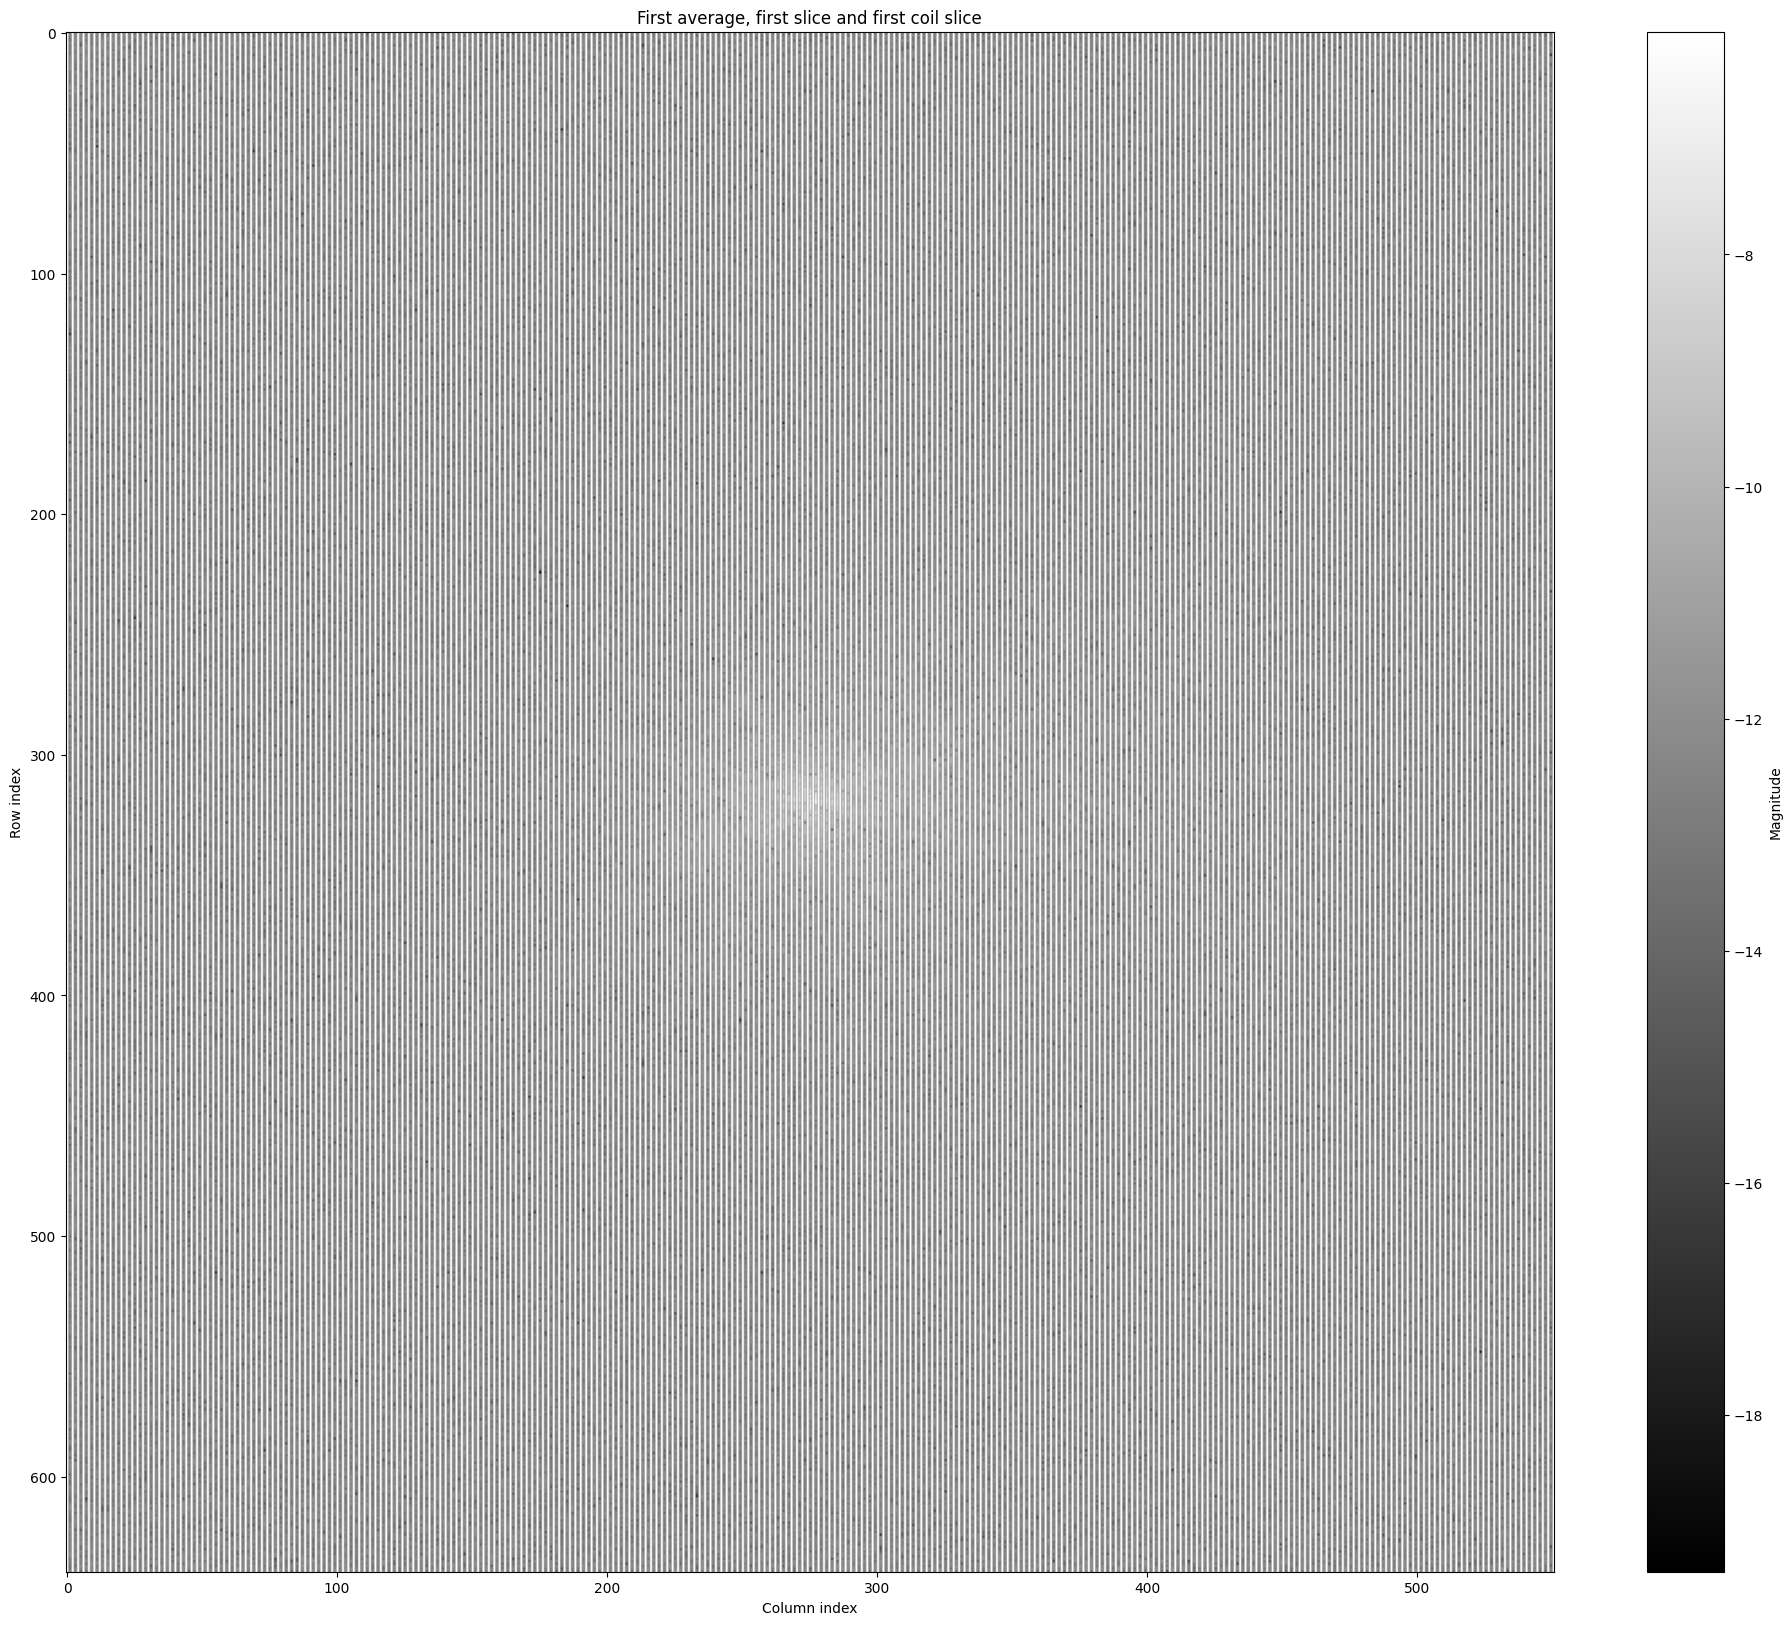

In [7]:
avg1, avg2, avg3 = 0, 1, 2
slice_idx = 0
coil_idx = 0
first_avg = kspaces[0]['kspace'][avg1]
print(f"First average shape: {first_avg.shape}")
coil_slice = first_avg[slice_idx, coil_idx, :]
print(f"First average, first slicea and first coil slice shape: {coil_slice.shape}")

plt.figure(figsize=(24, 20))
plt.imshow(np.log(np.abs(coil_slice)), cmap='gray', aspect='auto')
plt.title(f"First average, first slice and first coil slice")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.colorbar(label="Magnitude")
plt.show()

# Load in the H5 file and obtain the echo trains from the database

In [14]:
def fetch_echo_train_summary(
    patient_id: str,
    db_path: Union[str, Path],
    table_name: str,
    slice_index: int = 0,
    debug: bool = False
) -> pd.DataFrame:
    """
    Fetch per‑echo‑train column‑index summaries for a given patient & slice.

    Parameters
    ----------
    patient_id : str
        The seq_id of the patient.
    db_path : str or Path
        Path to the SQLite database file.
    table_name : str
        Name of the table containing acquisitions.
    slice_index : int, default=0
        Which slice to filter on (usually 0 for mapping).
    debug : bool, default=False
        If True, prints the resulting DataFrame.

    Returns
    -------
    pd.DataFrame
        Columns: ['id','avg_idx','echo_train_idx','col_indexes','sample_count'].
        - col_indexes is a comma‑separated string of the sampled column indices.
        - sample_count should equal the echo‑train length (e.g. 25).

    Raises
    ------
    ValueError
        If no rows are returned for the given patient & slice.
    RuntimeError
        On any database I/O error.
    """
    db_file = str(db_path)
    sql = f"""
    SELECT
      id,
      avg_idx,
      echo_train_idx,
      GROUP_CONCAT(col_idx, ',') AS col_indexes,
      COUNT(col_idx)              AS sample_count
    FROM {table_name}
    WHERE id   = ?
      AND slice_idx = ?
    GROUP BY avg_idx, echo_train_idx
    ORDER BY avg_idx, echo_train_idx
    ;
    """

    try:
        with sqlite3.connect(db_file) as conn:
            df = pd.read_sql_query(sql, conn, params=(patient_id, slice_index))
    except sqlite3.Error as e:
        raise RuntimeError(f"Unable to query echo‑train mapping: {e}")

    if df.empty:
        raise ValueError(
            f"No echo‑train summary found for patient={patient_id!r}, slice_idx={slice_index}"
        )

    if debug:
        print(f"[DEBUG] Echo‑train summary for {patient_id!r}, slice {slice_index}:\n", df)

    return df


# ——— Example usage ———
pid = pat_ids[0]
try:
    summary_df = fetch_echo_train_summary(pid, roots['db_fpath_new'], tablename, debug=True)
    # ensure each echo train has the expected number of lines
    ETL = 25
    bad = summary_df[summary_df['sample_count'] != ETL]
    if not bad.empty:
        print("Warning: some echo trains have unexpected sample counts:\n", bad)
except Exception as err:
    print("Error:", err)



[DEBUG] Echo‑train summary for '0004_ANON9616598', slice 0:
                   id  avg_idx  echo_train_idx  \
0   0004_ANON9616598        0               0   
1   0004_ANON9616598        0               1   
2   0004_ANON9616598        0               2   
3   0004_ANON9616598        0               3   
4   0004_ANON9616598        0               4   
5   0004_ANON9616598        0               5   
6   0004_ANON9616598        0               6   
7   0004_ANON9616598        0               7   
8   0004_ANON9616598        0               8   
9   0004_ANON9616598        0               9   
10  0004_ANON9616598        0              10   
11  0004_ANON9616598        1               0   
12  0004_ANON9616598        1               1   
13  0004_ANON9616598        1               2   
14  0004_ANON9616598        1               3   
15  0004_ANON9616598        1               4   
16  0004_ANON9616598        1               5   
17  0004_ANON9616598        1               6   
18  0004

# 🧪 Leave-X-Out (LXO) Echo Train Subsampling Strategy

We aim to generate uncertainty maps by leaving out a structured subset of echo trains per sub-reconstruction.

For example, if a patient has **13 echo trains**, we perform approximately half that number of reconstructions:

- `13 // 2 = 6` reconstructions
- In each sub-reconstruction, a different echo train is left out
- The **echo train that contains the central k-space line** is always retained to preserve image contrast

### 🔢 Example:
Given echo train indices:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]




Assume the central k-space line lies in **echo train index 2**.

The sub-reconstruction plans might look like:

- `recon1`: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
- `recon2`: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]
- `recon3`: [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12]
- `recon4`: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12]
- `recon5`: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12]
- `recon6`: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Each reconstruction retains all echo trains **except two**, except the center-containing echo train (index 2), which is **never dropped**.


In [31]:

def count_distinct_echo_trains(
    patient_id: str,
    db_filepath: Union[str, Path],
    table_name: str
) -> int:
    """
    Count how many distinct echo trains were acquired for slice 0 of the first average.

    Parameters
    ----------
    patient_id : str
        The patient sequence ID (seq_id in the DB).
    db_filepath : str or Path
        Path to the SQLite database file.
    table_name : str
        Name of the table containing echo‑train mapping.

    Returns
    -------
    int
        The number of distinct echo_train_idx found.

    Raises
    ------
    RuntimeError
        If there is any database I/O error.
    ValueError
        If the query returns no result (should not normally happen).
    """
    db_path = str(db_filepath)
    sql = f"""
    SELECT COUNT(DISTINCT echo_train_idx) 
      FROM {table_name}
     WHERE id = ?
       AND avg_idx  = 0
       AND slice_idx = 0
    ;
    """

    try:
        with sqlite3.connect(db_path) as conn:
            cursor = conn.execute(sql, (patient_id,))
            row = cursor.fetchone()
    except sqlite3.Error as e:
        raise RuntimeError(f"Database error counting echo trains: {e}")

    if row is None or row[0] is None:
        raise ValueError(
            f"No echo‑train entries found for patient={patient_id!r}, avg_idx=0, slice_idx=0"
        )

    # we expect a number anywere between 1 and 30 ish
    if row[0] < 1 or row[0] > 30:
        raise ValueError(
            f"Unexpected number of echo trains for patient={patient_id!r}: {row[0]}. we assert this is between 1 and 30. (please inspect this case)"
        )

    return int(row[0])


def find_middle_echo_train(
    ncols: int,
    summary_df: pd.DataFrame
) -> Tuple[int, int]:
    """
    Find which echo‑train (and which average) acquired the exact center ky line.

    Parameters
    ----------
    ncols : int
        Total number of k‑space columns (e.g. 651)
    summary_df : pd.DataFrame
        Output of fetch_echo_train_summary(), with columns:
        ['seq_id','avg_idx','echo_train_idx','col_indexes','sample_count']

    Returns
    -------
    (avg_idx, echo_train_idx)
        The average and echo‑train index that contains column ncols//2.

    Raises
    ------
    ValueError
        If no echo train contains the exact center column.
    """
    middle_col = ncols // 2
    print(f"Middle column Found to be: {middle_col}")
    # print(summary_df)
    for _, row in summary_df.iterrows():
        # turn "12,13,14,..." into [12,13,14,…]
        cols = list(map(int, row["col_indexes"].split(",")))
        if middle_col in cols:
            print(f"Found middle column {middle_col} in avg {row['avg_idx']}, echo train {row['echo_train_idx']}")
            return int(row["avg_idx"]), int(row["echo_train_idx"])

    raise ValueError(f"No echo train found containing center column {middle_col}")


# ————— Example usage —————
pid = pat_ids[0]
slice_idx = 0

# 1) How many echo trains in first average?
try:
    n_et = count_distinct_echo_trains(pid, roots['db_fpath_new'], tablename)
    print(f"Patient {pid!r}: {n_et} echo trains (avg=0, slice=0)")
except Exception as err:
    print(f"Error counting echo trains: {err}")

# 2) Load your full per‑acquisition DataFrame (from your earlier get_echo_train_mapping)
#    then identify which echo train hit the exact center column:
et_df = fetch_echo_train_summary(
    patient_id   = pid,
    db_path      = roots['db_fpath_new'],
    table_name   = tablename,
    slice_index  = slice_idx,
    debug        = False
)
cols = kspaces[0]['kspace'].shape[-1]
avg0, center_et = find_middle_echo_train(cols, et_df)
print(f"Center line was acquired in avg {avg0}, echo train {center_et}")


Patient '0004_ANON9616598': 11 echo trains (avg=0, slice=0)
Middle column Found to be: 275
Found middle column 275 in avg 0, echo train 2
Center line was acquired in avg 0, echo train 2


In [29]:
def fetch_echo_train_columns(
    patient_id: str,
    average_index: int,
    echo_train_index: int,
    db_filepath: Union[str, Path],
    table_name: str
) -> np.ndarray:
    """
    Retrieve the list of k‑space column indices for a single echo train
    (slice 0) of a given patient & average.

    Parameters
    ----------
    patient_id : str
        Unique patient identifier (seq_id in DB).
    average_index : int
        Which average repetition (cAve) to query.
    echo_train_index : int
        Which echo train number to query.
    db_filepath : str or Path
        Path to the SQLite database file.
    table_name : str
        Name of the table holding echo‑train mapping.

    Returns
    -------
    np.ndarray[int]
        1D array of column indices, sorted by their acquisition order.

    Raises
    ------
    RuntimeError
        On any database I/O error.
    ValueError
        If no rows are found, or the count != expected echo‑train length.
    TypeError
        If any retrieved index is not integer‑castable.
    """
    EXPECTED_ECHO_TRAIN_LENGTH = 25
    db_path_str = str(db_filepath)

    sql = f"""
    SELECT col_idx
      FROM {table_name}
     WHERE id             = ?
       AND avg_idx        = ?
       AND echo_train_idx = ?
       AND slice_idx      = 0
     ORDER BY inner_et_counter ASC
    ;
    """

    try:
        with sqlite3.connect(db_path_str) as conn:
            cursor = conn.execute(sql, (patient_id, average_index, echo_train_index))
            rows = cursor.fetchall()
    except sqlite3.Error as err:
        raise RuntimeError(f"Failed to query DB: {err}")

    if not rows:
        raise ValueError(
            f"No columns found for patient={patient_id!r}, "
            f"average={average_index}, echo_train={echo_train_index}"
        )

    # unpack and validate
    col_list = [item[0] for item in rows]
    if any(not isinstance(ci, (int, np.integer)) for ci in col_list):
        raise TypeError("Retrieved col_idx values must all be integers")

    if len(col_list) != EXPECTED_ECHO_TRAIN_LENGTH:
        raise ValueError(
            f"Echo train length mismatch: expected {EXPECTED_ECHO_TRAIN_LENGTH} "
            f"columns but got {len(col_list)} for patient={patient_id!r}, "
            f"average={average_index}, echo_train={echo_train_index}"
        )

    return np.array(col_list, dtype=int)


# ————— Example usage —————
pid   = pat_ids[0]
avg   = 0
et    = 0

try:
    columns = fetch_echo_train_columns(
        patient_id       = pid,
        average_index    = avg,
        echo_train_index = et,
        db_filepath      = roots['db_fpath_new'],
        table_name       = tablename
    )
    print(f"Echo‑train {et} columns for patient {pid}, avg {avg}: {columns}")
except Exception as e:
    print(f"Error: {e}")

Echo‑train 0 columns for patient 0004_ANON9616598, avg 0: [429 411 393 375 357 339 321 303 285 267 249 231 213 195 177 159 141 123
 105  87  69  51  33  15 547]


In [32]:
# --- Helper stubs (assume these are defined elsewhere in your notebook) ---
# fetch_echo_train_columns(patient_id, avg_idx, echo_train_idx, db_path, table_name) -> np.ndarray
# count_distinct_echo_trains(patient_id, db_path) -> int
# find_middle_echo_train(n_cols, echo_train_summary_df) -> Tuple[int, int]
# fetch_echo_train_summary(patient_id, db_path, table_name, slice_index, debug) -> pd.DataFrame
# -----------------------------------------------------------------------------


def generate_r3_undersampled_kspaces(
    full_kspace: np.ndarray,
    patient_id: str,
    db_path: Path,
    echo_train_table: str,
    average_index: int = 0
) -> List[np.ndarray]:
    """
    Create R=3 undersampled k‑space variants by dropping two echo‑trains at a time,
    never omitting the echo‑train containing the k‑space center line.

    Parameters
    ----------
    full_kspace : np.ndarray
        Shape (n_avgs, n_slices, n_coils, n_rows, n_cols).
    patient_id : str
    db_path : Path
    echo_train_table : str
    average_index : int, default 0

    Returns
    -------
    undersampled_kspaces : List[np.ndarray]
        Each element is a copy of full_kspace[average_index] with two echo‑trains zeroed out.
    """
    # 1) Load echo‐train summary and count
    et_df = fetch_echo_train_summary(
        patient_id, db_path, echo_train_table, slice_index=0, debug=False
    )
    total_echo_trains = count_distinct_echo_trains(patient_id, db_path, echo_train_table)
    print(f"  • found {total_echo_trains} echo trains")

    # 2) Pick out the average
    ksp_avg = full_kspace[average_index]  # shape (n_slices, n_coils, n_rows, n_cols)
    n_cols = ksp_avg.shape[-1]
    print(f"  • k‑space shape for avg {average_index}: {ksp_avg.shape}")
    print(f"  • found n_cols={n_cols} columns")

    # 3) Identify center echo‐train (contains middle column)
    _, center_et = find_middle_echo_train(n_cols, et_df)
    print(f"  • center echo‐train index: {center_et}")

    # 4) Build map variant_idx → two echo‐trains to drop
    valid_ets = [et for et in range(total_echo_trains) if et != center_et]
    n_variants = total_echo_trains // 2
    echo_train_dropout_map = {
        idx: valid_ets[2*idx : 2*idx + 2]
        for idx in range(n_variants)
    }
    print(f"  • exclusion map: {echo_train_dropout_map}")

    # 5) Generate undersampled sets
    undersampled_sets = []
    for variant_idx, ets_to_drop in echo_train_dropout_map.items():
        # fetch & concatenate their column indices
        cols_drop = np.concatenate([
            fetch_echo_train_columns(
                patient_id, average_index, et_idx, db_path, echo_train_table
            )
            for et_idx in ets_to_drop
        ])
        cols_drop = np.unique(cols_drop)
        print(f"    Variant {variant_idx}: dropping {len(cols_drop)} lines (first 5 → {cols_drop[:5]}) (last 5 → {cols_drop[-5:]})")

        # zero out in one shot
        ksp_copy = ksp_avg.copy()
        ksp_copy[..., cols_drop] = 0
        undersampled_sets.append(ksp_copy)

    return undersampled_sets, echo_train_dropout_map

# --- Example usage ---
kspace = kspaces[0]['kspace']   # loaded earlier
pid = kspaces[0]['id']  # loaded earlier
accel_factors = [3]  # R=3 case only

for R in accel_factors:
    print(f"→ Patient {pid}, acceleration R={R}")
    undersampled_kspaces, et_dropout_map = generate_r3_undersampled_kspaces(
        full_kspace      = kspace,
        patient_id       = pid,
        db_path          = roots['db_fpath_new'],
        echo_train_table = tablename,
        average_index    = 0
    )
    print(f"Generated {len(undersampled_kspaces)} undersampled k‑spaces for R=3")

print(f"Undersampled k-space shape: {undersampled_kspaces[0].shape}")


→ Patient 0004_ANON9616598, acceleration R=3
  • found 11 echo trains
  • k‑space shape for avg 0: (31, 26, 640, 551)
  • found n_cols=551 columns
Middle column Found to be: 275
Found middle column 275 in avg 0, echo train 2
  • center echo‐train index: 2
  • exclusion map: {0: [0, 1], 1: [3, 4], 2: [5, 6], 3: [7, 8], 4: [9, 10]}
    Variant 0: dropping 50 lines (first 5 → [15 17 33 35 51]) (last 5 → [413 429 431 547 549])
    Variant 1: dropping 50 lines (first 5 → [ 3  9 21 23 39]) (last 5 → [407 417 423 435 437])
    Variant 2: dropping 50 lines (first 5 → [ 7 11 27 29 41]) (last 5 → [405 419 425 433 443])
    Variant 3: dropping 50 lines (first 5 → [ 5 13 25 31 45]) (last 5 → [409 421 427 439 445])
    Variant 4: dropping 50 lines (first 5 → [447 449 451 453 455]) (last 5 → [537 539 541 543 545])
Generated 5 undersampled k‑spaces for R=3
Undersampled k-space shape: (31, 26, 640, 551)


## Now we have 6 masked k-spaces, lets make a reconstruction grid out of them.

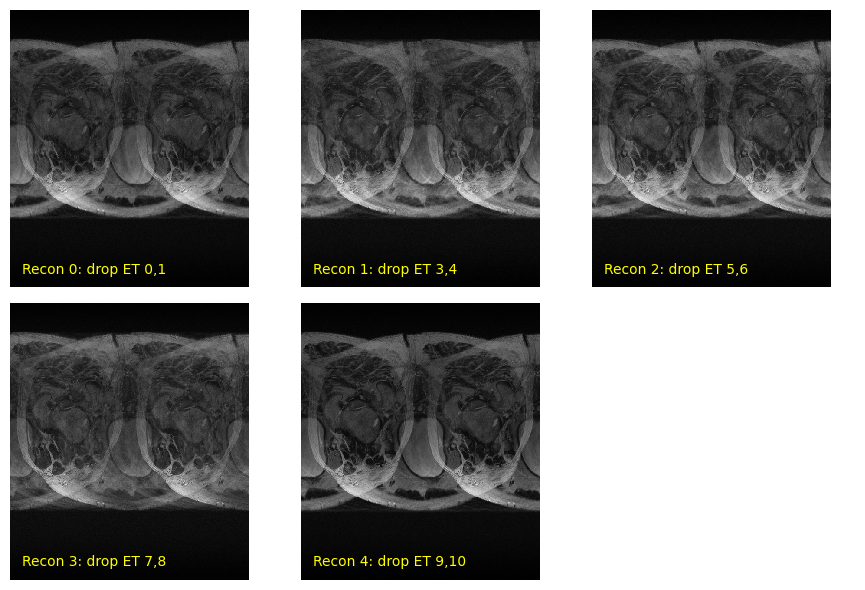

In [35]:
def plot_undersampled_reconstructions(
    undersampled_kspaces: List[np.ndarray],
    echo_train_dropout_map: Dict[int, List[int]],    # ← added
    slice_index: int = 0,
    coil_combine = None,
    grid_shape: Tuple[int,int] = (2,3)
):
    """
    Plot a grid of reconstructed images from undersampled k-space variants.

    Parameters
    ----------
    undersampled_kspaces : List[np.ndarray]
        List of k-space arrays, each with shape (nslices, ncoils, nrows, ncols).
    slice_index : int
        The slice index to reconstruct and display.
    grid_shape : (rows, cols)
        Tuple specifying the grid layout (num rows, num cols).
    coil_combine : bool
        If True, combine coils by root-sum-of-squares. Otherwise, plot a single coil.
    """
    n_variants = len(undersampled_kspaces)
    nrows, ncols = grid_shape
    assert nrows * ncols >= n_variants, "Grid shape too small for number of variants"
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten()
    
    for idx, ksp in enumerate(undersampled_kspaces):
        # extract the chosen slice
        ksp_slice = ksp[slice_index]  # shape (ncoils, nrows, ncols)
        
        # ifftshift, ifft2, then ifftshift back
        img = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(ksp_slice, axes=(-2, -1))), axes=(-2, -1))
        
        if coil_combine:
            # root-sum-of-squares across coils
            img_comb = np.sqrt(np.sum(np.abs(img)**2, axis=0))
        else:
            # just the first coil
            img_comb = np.abs(img[0])
        
        ax = axes[idx]
        ax.imshow(np.abs(img_comb), cmap='gray', interpolation='nearest')
        ax.axis('off')
        # overlay variant number in yellow
        ets = echo_train_dropout_map[idx]
        ax.text(0.05, 0.05, f"Recon {idx}: drop ET {ets[0]},{ets[1]}", color='yellow', transform=ax.transAxes)
    
    # turn off any unused axes
    for ax in axes[n_variants:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()



# Example call:
plot_undersampled_reconstructions(
    undersampled_kspaces,
    et_dropout_map,
    slice_index=16,
    grid_shape=(2, 3),
    coil_combine=True)

# Now with Uncertainty Map (on R=3)

* Method A: Standard Deviation. 
* Method B: Normalized Standard Deviation

Reconstructed images shape: (5, 640, 551)


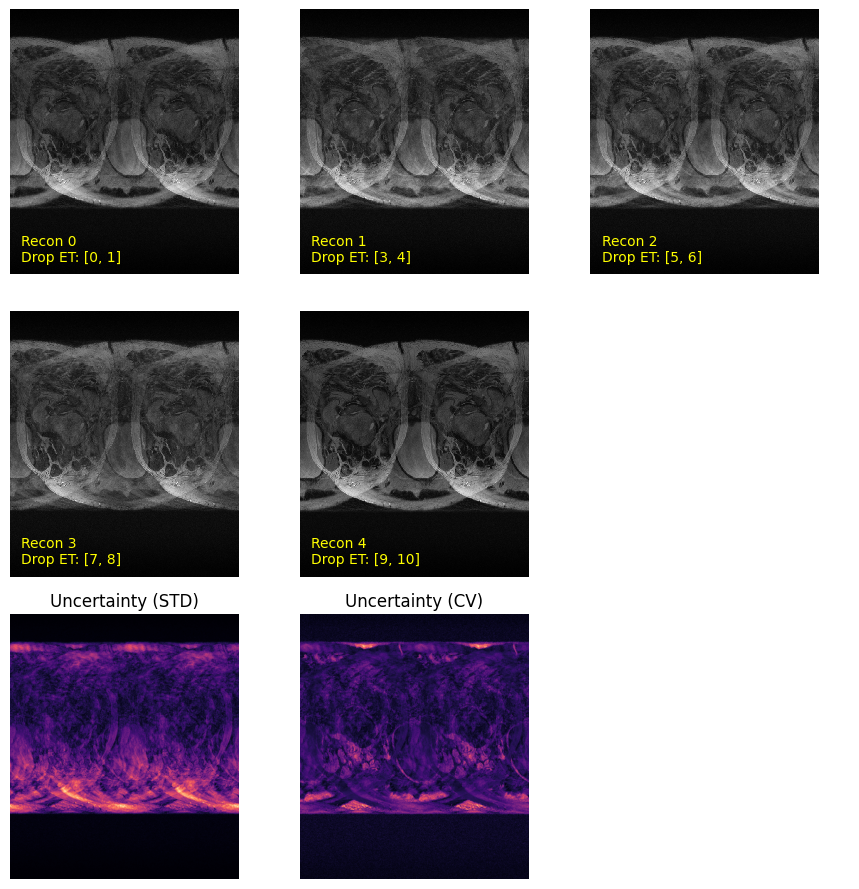

In [ ]:
def plot_undersampled_reconstructions(
    undersampled_kspaces: List[np.ndarray],
    echo_train_dropout_map: Dict[int, List[int]],
    slice_index: int = 0,
    coil_combine=True,
    grid_shape: Tuple[int, int] = (2, 3)
):
    """
    Plot a grid of reconstructed images from undersampled k-space variants,
    with additional uncertainty maps (STD and Coefficient of Variation).

    Parameters
    ----------
    undersampled_kspaces : List[np.ndarray]
        List of k-space arrays, each with shape (nslices, ncoils, nrows, ncols).
    echo_train_dropout_map : Dict[int, List[int]]
        Mapping from variant index to list of dropped echo train indices.
    slice_index : int
        Slice to display.
    coil_combine : bool
        If True, apply root-sum-of-squares coil combination.
    grid_shape : (int, int)
        Grid shape for reconstructions (rows, cols).
    """
    n_variants = len(undersampled_kspaces)
    nrows, ncols = grid_shape
    assert nrows * ncols >= n_variants, "Grid shape too small for number of variants"

    # Reconstruct all images
    recon_images = []
    for ksp in undersampled_kspaces:
        ksp_slice = ksp[slice_index]
        img = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(ksp_slice, axes=(-2, -1))), axes=(-2, -1))
        if coil_combine:
            img_comb = np.sqrt(np.sum(np.abs(img) ** 2, axis=0))
        else:
            img_comb = np.abs(img[0])
        recon_images.append(img_comb)

    recon_images = np.stack(recon_images, axis=0)  # shape: (n_recons, H, W)
    print(f"Reconstructed images shape: {recon_images.shape}")

    # Compute uncertainty maps
    std_map = np.std(recon_images, axis=0)
    mean_map = np.mean(recon_images, axis=0)
    cv_map = np.divide(std_map, mean_map + 1e-8)  # add epsilon to avoid div by zero

    # Total rows = original + 1 (for uncertainty maps)
    total_rows = nrows + 1
    fig, axes = plt.subplots(total_rows, ncols, figsize=(ncols * 3, total_rows * 3))

    # Plot all reconstructions
    for idx in range(n_variants):
        ax = axes[idx // ncols, idx % ncols]
        ax.imshow(recon_images[idx], cmap='gray', interpolation='nearest')
        ax.axis('off')
        ets = echo_train_dropout_map[idx]
        ax.text(0.05, 0.05, f"Recon {idx}\nDrop ET: {ets}", color='yellow', transform=ax.transAxes)

    # Plot STD and CV maps in last row
    ax_std = axes[-1, 0]
    ax_cv = axes[-1, 1]
    ax_std.imshow(std_map, cmap='magma')
    ax_std.set_title("Uncertainty (STD)")
    ax_std.axis('off')
    ax_cv.imshow(cv_map, cmap='magma')
    ax_cv.set_title("Uncertainty (CV)")
    ax_cv.axis('off')

    # Turn off any unused axes
    for i in range(n_variants, nrows * ncols):
        axes[i // ncols, i % ncols].axis('off')
    for j in range(2, ncols):
        axes[-1, j].axis('off')

    plt.tight_layout()
    plt.show()



# Example call:
plot_undersampled_reconstructions(
    undersampled_kspaces,
    et_dropout_map,
    slice_index=16,
    grid_shape=(2, 3),
    coil_combine=True
)


# create the R6 mask


(768, 651)
0.500768049155146


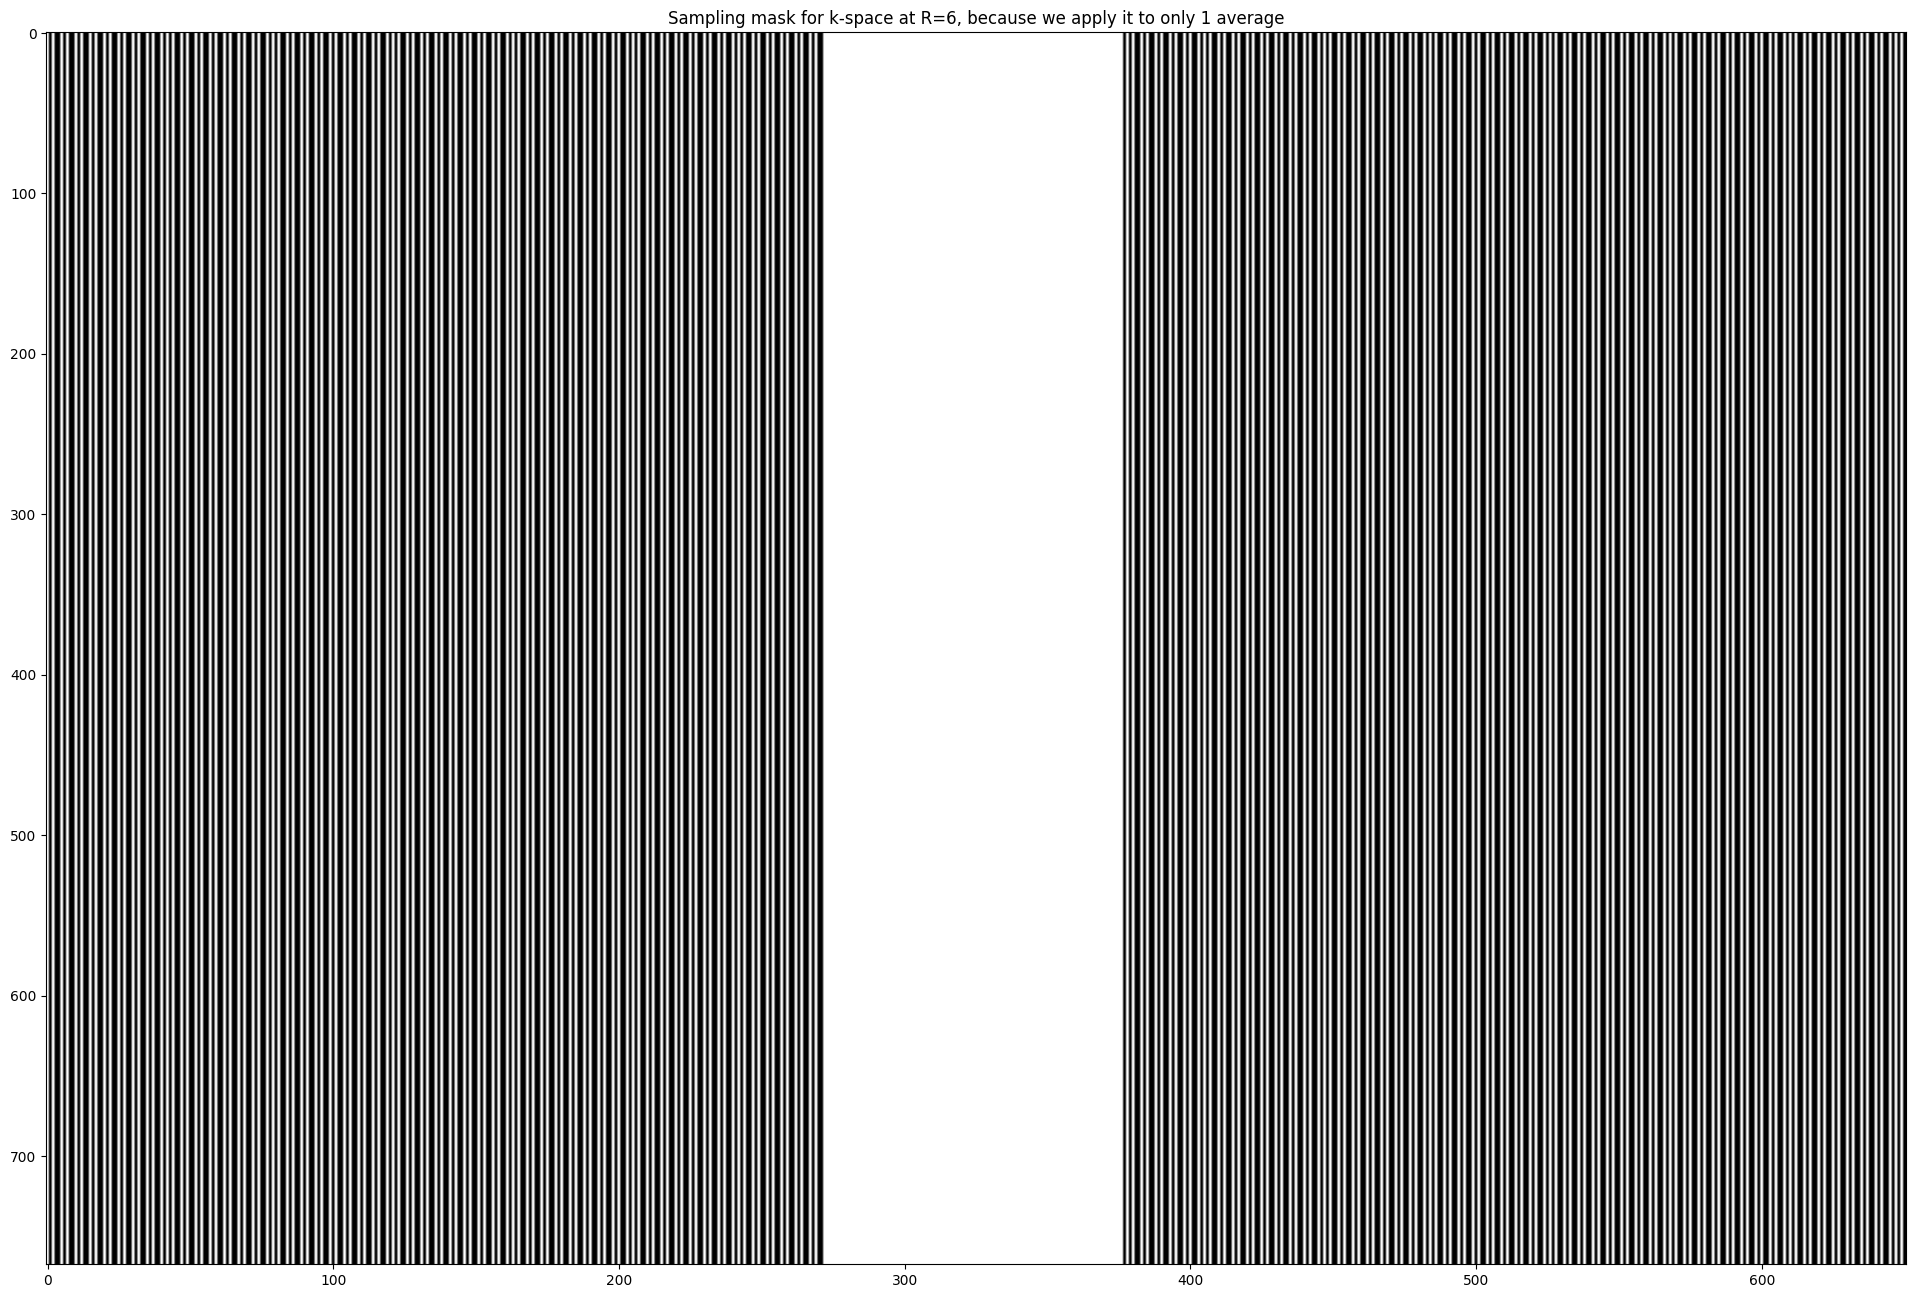

In [ ]:
def create_mask(shape: Tuple[int, ...], accelerations: List[int], center_fractions: List[float]) -> np.ndarray:
    """
    Build a 2D sampling mask for k‑space.

    Parameters
    ----------
    shape : tuple of int
        K‑space shape, e.g. (30,20,768,651) or simply (rows, cols).
    accelerations : list of int
        e.g. [2] → overall acceleration factor ≈ 1+2=3×
    center_fractions : list of float
        e.g. [0.16] → 16% of center columns fully sampled.

    Returns
    -------
    mask : ndarray of bool, shape (rows, cols)
    """
    # get rows & cols
    if len(shape) > 2:
        rows, cols = shape[-2], shape[-1]
    else:
        rows, cols = shape

    accel = accelerations[0]
    cf    = center_fractions[0]

    # number of central (low‑freq) columns to keep
    num_low = int(round(cols * cf))
    cstart  = (cols - num_low) // 2

    # start with an empty mask
    mask = np.zeros((rows, cols), dtype=bool)

    # fill the center region
    mask[:, cstart:cstart + num_low] = True

    # compute equispaced sampling for the rest:
    # adjusted_accel = (accel * (num_low - cols)) / (num_low * accel - cols)
    adj = (accel * (num_low - cols)) / (num_low * accel - cols)

    # deterministically start at offset zero
    samp = np.arange(0, cols, adj)
    samp = np.round(samp).astype(int)
    samp = samp[(samp < cols) & (samp < cstart) | (samp >= cstart + num_low)]  # exclude already‑sampled center

    # mark those positions
    mask[:, samp] = True

    return mask


# example
ksp_shape = (30, 20, 768, 651)
mask = create_mask(ksp_shape, accelerations=[2], center_fractions=[0.16])
print(mask.shape)   # (768, 651)
print(mask.mean())  # ~1/3 of entries True (i.e. ≈3× accel)


# lets just visualize the mask with matplotlib
fig = plt.figure(figsize=(24, 16))
plt.imshow(mask, cmap='gray', aspect='auto')
plt.title("Sampling mask for k-space at R=6, because we apply it to only 1 average")
plt.show()



# Lets create the mask without central sampling.

Percentage of lines sampled: 33.33%


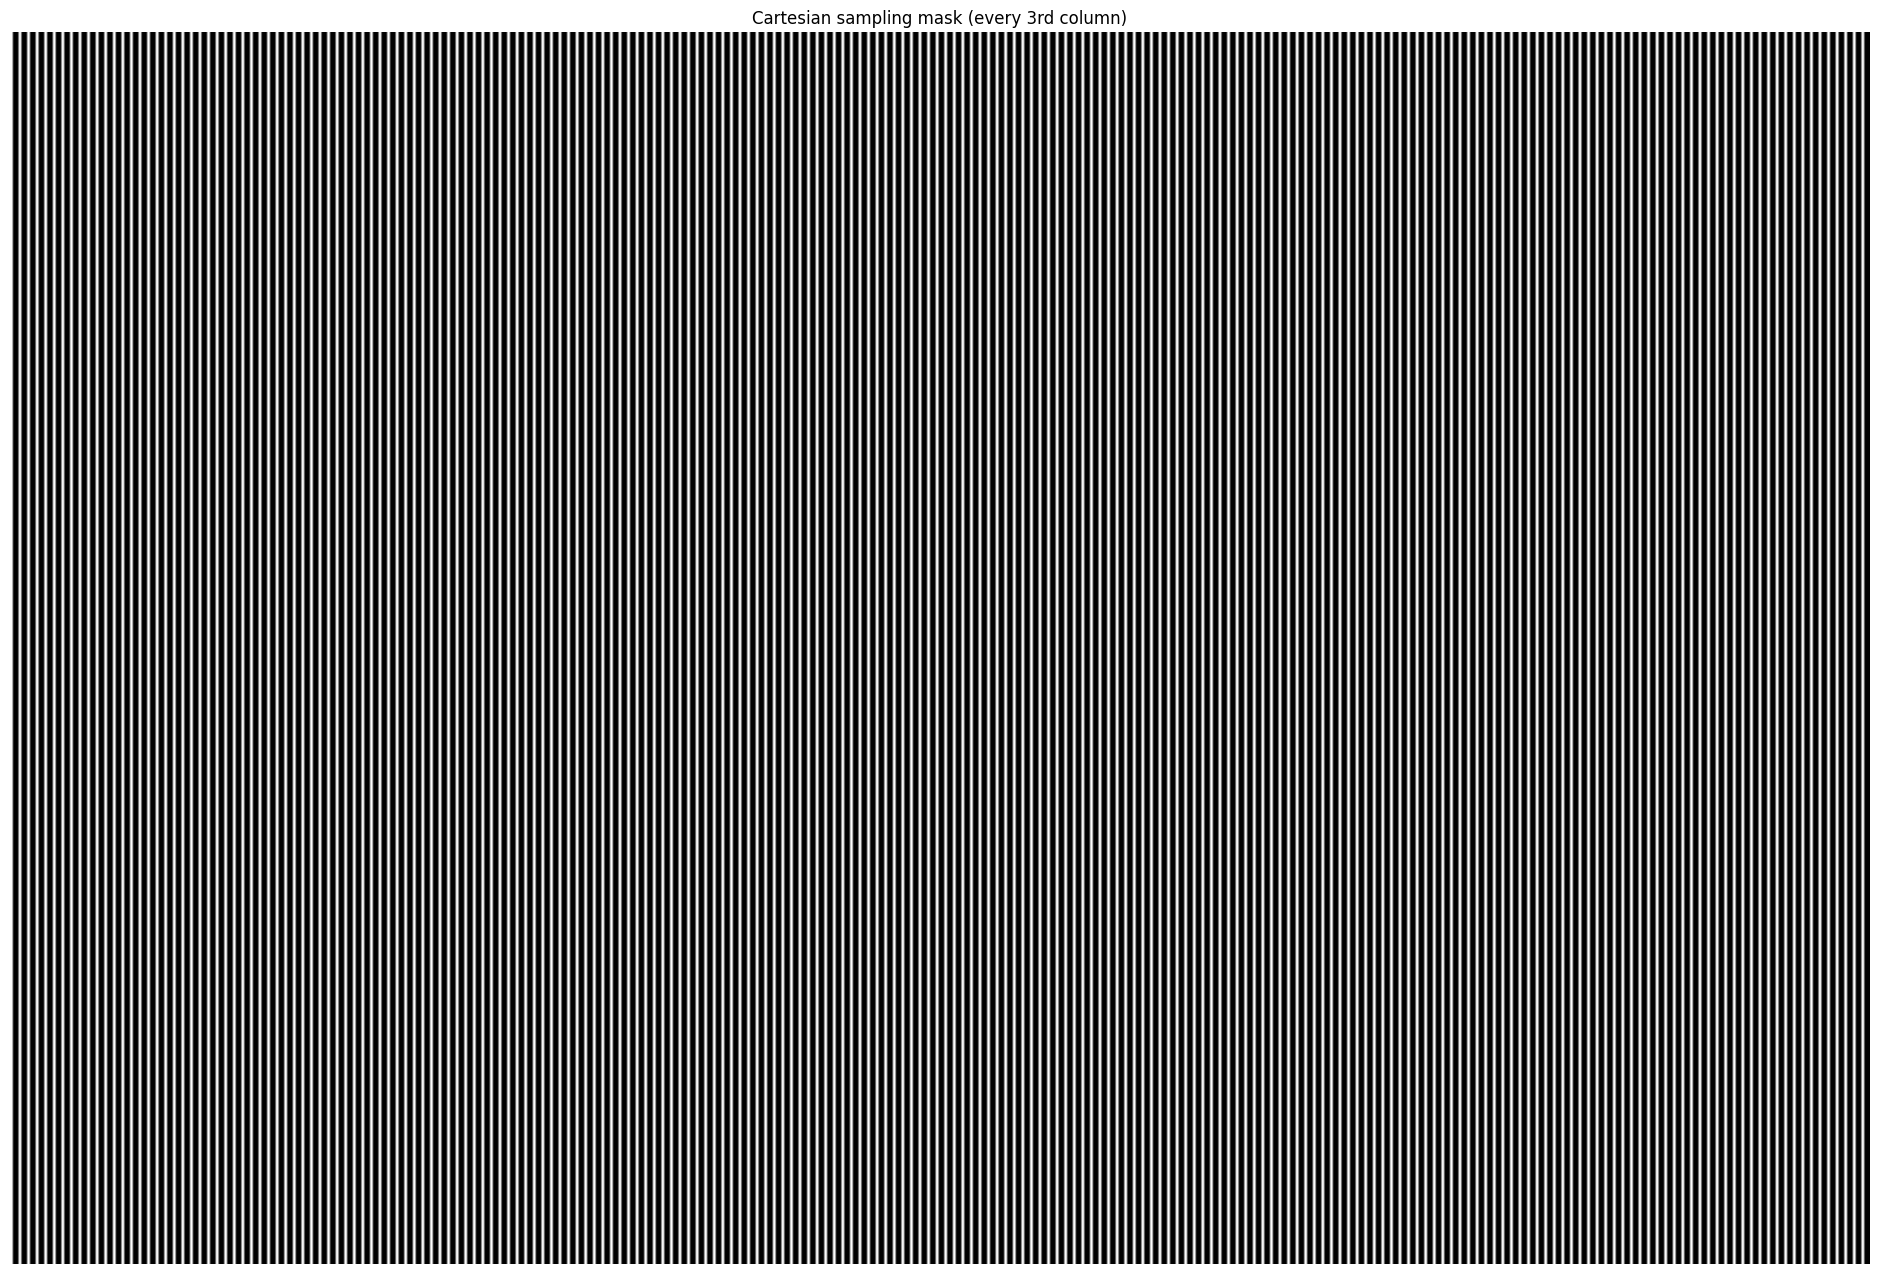

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def build_cartesian_mask(kspace_shape: tuple, acceleration: int) -> np.ndarray:
    """
    Generate a 2D Cartesian sampling mask by uniformly subsampling columns.

    Parameters
    ----------
    kspace_shape : tuple of int
        Full k-space shape, e.g. (n_slices, n_coils, n_rows, n_cols) or (n_rows, n_cols).
    acceleration : int
        Cartesian acceleration factor (e.g. 3 → keep every 3rd column).

    Returns
    -------
    mask : ndarray of bool, shape (n_rows, n_cols)
    """
    n_rows, n_cols = kspace_shape[-2], kspace_shape[-1]
    mask = np.zeros((n_rows, n_cols), dtype=bool)
    mask[:, ::acceleration] = True

    # percentage of lines sampled. We compute it emperically based on the mask
    percentage_sampled = np.sum(mask) / (n_rows * n_cols)
    print(f"Percentage of lines sampled: {percentage_sampled:.2%}")

    return mask

# Example usage:
mask = build_cartesian_mask((30, 20, 768, 651), acceleration=3)

plt.figure(figsize=(24, 16))
plt.imshow(mask, cmap='gray', aspect='auto')
plt.title("Cartesian sampling mask (every 3rd column)", color='black')
plt.axis('off')
plt.show()
